In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.linalg import svd

import grakel as gk
from grakel.kernels import WeisfeilerLehman
from grakel.utils import graph_from_networkx

In [2]:
with open('../graphs/export_graphs.pkl', 'rb') as file:
    export_graphs = pkl.load(file)

In [77]:
def normalize_similarity(similarity):
    """
    Normalize similarity values between 0 and 1.
    """
    min_val = np.min(similarity)
    max_val = np.max(similarity)
    normalized_similarity = (similarity - min_val) / (max_val - min_val)
    return normalized_similarity

In [78]:
def pairwise_distance(graphs, dist_type):
    """
    Create pairwise matrix which contains the distance for every pair of graphs

    #Parameters
    graphs - list of graphs
    dist_type - specified distance function
    """
    i = len(graphs)
    distances = np.zeros(shape=(i,i))
    for i in range(len(graphs)):
        for j in range(len(graphs)):
            distances[i][j] = dist_type(graphs[i], graphs[j])
    return distances

In [101]:
from netrd.distance import JaccardDistance
def jaccard_distance(G1, G2):
    # Convert the graphs to edge sets
    jacc = JaccardDistance()

    distance = jacc.dist(G1, G2)

    return distance

In [102]:
jaccard_distances = pairwise_distance(export_graphs, jaccard_distance)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [76]:
from netrd.distance import Frobenius
def frobenius_distance(G1, G2):

    fro = Frobenius()

    distance = fro.dist(G1, G2)

    return distance

In [79]:
frobenius_distances = pairwise_distance(export_graphs, frobenius_distance)

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:118: RuntimeWarning: Coercing weighted graph to unweighted.
  warnings.warn("Coercing weighted graph to unweighted.", RuntimeWarning)


In [83]:
frobenius_norm = normalize_similarity(np.array(frobenius_distances))
frobenius_norm = 1-frobenius_norm

In [12]:
def wl_distance(t1, t2):
    for g in export_graphs:
        nx.set_node_attributes(g, 1, 'label')

        # Assuming G1 and G2 are your graphs
        G = graph_from_networkx(export_graphs, node_labels_tag='label')

        # Initialize a Weisfeiler-Lehman kernel
        gk = WeisfeilerLehman(normalize=True)

        G
        # Compute the kernel matrix
        kernel_matrix = gk.fit_transform(G)

    return kernel_matrix[t1, t2]

In [65]:
from netrd.distance import DeltaCon
# Initialize DeltaCon
def deltacon_distance(G1, G2):
    dc = DeltaCon()

    distance = dc.dist(G1, G2)

    return distance

In [66]:
deltacon_distances_exports = pairwise_distance(export_graphs, deltacon_distance)
deltacon_norm = normalize_similarity(np.array(deltacon_distances_exports))

/Users/sinclaireschuetze/anaconda3/lib/python3.11/site-packages/netrd/utilities/graph.py:74: RuntimeWarning: Coercing directed graph to undirected.
  warnings.warn("Coercing directed graph to undirected.", RuntimeWarning)
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


In [14]:
for g in export_graphs:
    nx.set_node_attributes(g, 1, 'label')

# Assuming G1 and G2 are your graphs
G = graph_from_networkx(export_graphs, node_labels_tag='label')

# Initialize a Weisfeiler-Lehman kernel
gk = WeisfeilerLehman(normalize=True)

# Compute the kernel matrix
kernel_matrix = gk.fit_transform(G)

## Average Similarity Statistic

In [39]:
def get_change_points(matrix, L):
    years = range(1962,2022)
    Z = []

    for t in range(L, len(years)):
        avg_sim = 0
        for i in range(1,L+1):
            avg_sim += matrix[t][t-i]
        Z.append(avg_sim/L)

    return Z

In [103]:
fro_change_points = get_change_points(frobenius_norm, 5)
wl_change_points = get_change_points(kernel_matrix, 5)
jacc_change_points = get_change_points(jaccard_distances, 5)
deltacon_change_point = get_change_points(deltacon_norm, 5)

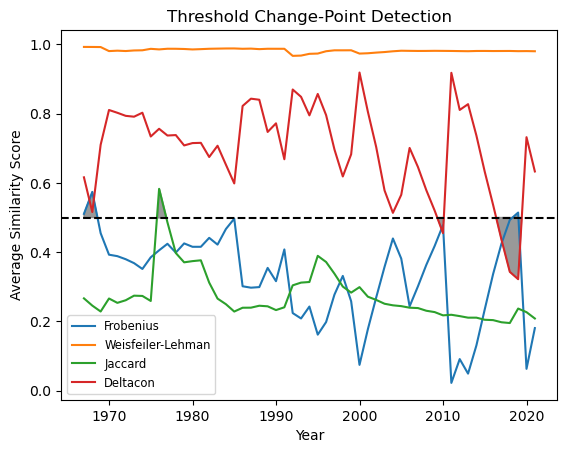

In [110]:
# Create a line graph of r_stat
l = 5

t_range = range(1962+l,2022)

fro_change_points = np.array(fro_change_points)
wl_change_points = np.array(wl_change_points)
jacc_change_points = np.array(jacc_change_points)
deltacon_change_point = np.array(deltacon_change_point)

plt.plot(t_range,fro_change_points, label='Frobenius')
plt.plot(t_range,wl_change_points, label='Weisfeiler-Lehman')
plt.plot(t_range,jacc_change_points, label='Jaccard')
plt.plot(t_range,deltacon_change_point, label='Deltacon')
plt.axhline(0.5, color='black', linestyle='--')

plt.fill_between(t_range, deltacon_change_point, 0.5, where=(deltacon_change_point < 0.5), interpolate=True, color='gray', alpha=0.8)
plt.fill_between(t_range, fro_change_points, 0.5, where=(fro_change_points > 0.5), interpolate=True, color='gray', alpha=0.8)
plt.fill_between(t_range, jacc_change_points, 0.5, where=(jacc_change_points > 0.5), interpolate=True, color='gray', alpha=0.8)

plt.title('Threshold Change-Point Detection')
plt.xlabel('Year')
plt.ylabel('Average Similarity Score')
plt.legend(fontsize='small')
plt.show()